# From raw text to understanding.

This code is showcase of the diverse *natural language processing* techniques one can use to :
- automatically classify sentences depending on the sentiment or category
- extract representation of words and sentences to understand text
- etc.

## 0. loading packages

In [101]:
import os, sys
import codecs
import gensim
import pickle
import nltk
import string
import random
import sqlite3
import time
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
'''Reproducibility settings'''
random.seed(100)

## 1. loading and quick inspection of data

We start here by loading our dataset stored in a sqlite database and inspect very quickly. We also load the config path where we will store any (hyper-)parameters or parameters we will be willing to use later in our code.

In [7]:
data_path = '../data'
config_path = '../config'

### 👉 quick description

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories. As a reminder it can be found [here](https://www.kaggle.com/snap/amazon-fine-food-reviews) on kaggle or [here](http://snap.stanford.edu/data/web-FineFoods.html) on SNAP (original source).

This dataset consists of a single table, **Reviews**.

In [262]:
con = sqlite3.connect(os.path.join(data_path, 'database.sqlite'))
cursor = con.cursor()

In [265]:
%time table = pd.read_sql_query("SELECT * FROM Reviews;", con)

CPU times: user 3.07 s, sys: 835 ms, total: 3.9 s
Wall time: 4.45 s


In [266]:
table.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 👉 perfect showcase

The columns in the table are:

- `Id`
- `ProductId` - unique identifier for the product
- `UserId` - unqiue identifier for the user
- `ProfileName`
- `HelpfulnessNumerator` - number of users who found the review helpful
- `HelpfulnessDenominator` - number of users who indicated whether they found the review helpful
- `Score` - rating between 1 and 5
- `Time` - timestamp for the review
- `Summary` - brief summary of the review
- `Text` - text of the review


This is a perfect example of dataset that a business might be able to gather by sending survey to its customers. We have a `Score` that we can use to create sentiment categories (positive/neutral/negative) and we have a free-text field `Text` where customers can freely enter a review. Data will probably be *messy* and unbalanced (like usual), hence the perfect showcase here.

In [272]:
table.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


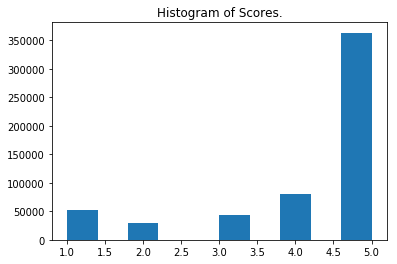

In [273]:
plt.hist(table.Score)
plt.title("Histogram of Scores.")
plt.show()

### 👉 preparing for sentiment classification

We can assume that a score of 4 or greater is *Positive* and that a score lower than 3 strictly is *Negative*. The rest will be *Neutral*

In [47]:
def assign_sentiment(score, label=False):
    if score > 3:
        return "Positive" if not label else 1
    elif score < 3:
        return "Negative" if not label else 3
    else:
        return "Neutral" if not label else 2

In [48]:
table['Sentiment'] = table.Score.apply(assign_sentiment)
table['ClassLabel'] = table.Score.apply(assign_sentiment, label=True)

In [49]:
table.Sentiment.value_counts()

Positive    443777
Negative     82037
Neutral      42640
Name: Sentiment, dtype: int64

As predicted, the dataset is completely imbalanced. We will balance it later probably by sub-sampling here but we can also make use of different sampling techniques such as SMOTE (see the [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/) package for more detailed and this paper on [SMOTE](https://www.jair.org/media/953/live-953-2037-jair.pdf)).

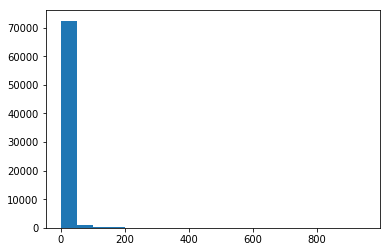

In [50]:
plt.hist([table.ProductId.value_counts()], bins=np.arange(0,1000,50))
plt.show()

In [53]:
data = table[['ProductId', 'Score', 'Summary', 'Text', 'Sentiment', 'ClassLabel']]

In [54]:
data.head()

,ProductId,Score,Summary,Text,Sentiment,ClassLabel
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,3
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,Negative,3
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


We can now decide to focus only on the relevant columns and dump the rest.

In [59]:
data.to_csv(os.path.join(data_path, 'data_raw.csv'))

## 2. transform the data

### 👉 sanitizing the data

Now that we have our dataset , we want to make sure our reviews only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [58]:
def sanitize_data(data_path, filename):
    input_file = codecs.open(os.path.join(data_path, filename + '.csv'), "r", encoding='utf-8', errors='replace')
    output_file = open(os.path.join(data_path, filename + '_clean.csv'), "w")

    def sanitize_characters(raw, clean):    
        for line in input_file:
            out = line
            output_file.write(line)

    return sanitize_characters(input_file, output_file)

In [60]:
sanitize_data(data_path, 'data_raw')

We can now reload the data.

In [274]:
data = pd.read_csv(open(os.path.join(data_path, 'data_raw_clean.csv'), 'r'), index_col = 'Unnamed: 0', error_bad_lines=False, engine='c')

In [275]:
data.head()

,ProductId,Score,Summary,Text,Sentiment,ClassLabel
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,3
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,Negative,3
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


### 👉 cleaning the data

Like we often say, "garbage in, garbage out". This is very true in the data science field when it comes to using machine learning or any techniques to play with data. In order to clean the data, we will here using several techniques to come up with a *cleaner* text.

Let's grab only 3 sentences to explain the pipeline.

In [285]:
text_test = data.Text.loc[59:62].tolist()
text_test

['Halloween is over but, I sent a bag to my daughters class for her share. The chocolate was fresh and enjoyed by many.',
 'Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.',
 'This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy',
 'Arrived in 6 days and were so stale i could not eat any of the 6 bags!!']


- We first want to compress punctuation characters to be able later on to split our text by sentences. 

In [313]:
import re

# compress characters
def compress_characters(text):
    return re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", text)

In [314]:
pipeline_test = [compress_characters(x) for x in text_test]
pipeline_test

['Halloween is over but, I sent a bag to my daughters class for her share. The chocolate was fresh and enjoyed by many.',
 'Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.',
 'This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy',
 'Arrived in 6 days and were so stale i could not eat any of the 6 bags!']

- We can now move onto the removal of special characters and on the standardization of our free-text data.

In [315]:
def standardize_text(text):
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"@\S+", "")
    text = text.replace("\\", "")
    text = text.replace("/", "")
    text = text.replace(r"[^A-Za-z0-9(),*!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")
    text = text.lower()
    return text

In [316]:
pipeline_test = [standardize_text(x) for x in pipeline_test]
pipeline_test

['halloween is over but, i sent a bag to my daughters class for her share. the chocolate was fresh and enjoyed by many.',
 'watch your prices with this.  while the assortment was good, and i did get this on a gold box purchase, the price for this was<br >$3-4 less at target.',
 'this bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy',
 'arrived in 6 days and were so stale i could not eat any of the 6 bags!']

- We still have many weid characters but the data is getting cleaner. It is now time to split our comments in separate sentences and then tokenize our sentences to a list of separate words.

In [317]:
from nltk import sent_tokenize

pipeline_test = [sent_tokenize(x) for x in pipeline_test]
pipeline_test

[['halloween is over but, i sent a bag to my daughters class for her share.',
  'the chocolate was fresh and enjoyed by many.'],
 ['watch your prices with this.',
  'while the assortment was good, and i did get this on a gold box purchase, the price for this was<br >$3-4 less at target.'],
 ['this bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy'],
 ['arrived in 6 days and were so stale i could not eat any of the 6 bags!']]

In [318]:
from nltk.tokenize import RegexpTokenizer

# tokrenize sentences
def tokenize(comment):
    tokenizer = RegexpTokenizer(r'\w+')
    try:
        tokens = tokenizer.tokenize(comment)
        return tokens
    except:
        return 'NC'

In [319]:
pipeline_test = [[tokenize(x) for x in text] for text in pipeline_test]

In [320]:
_ = [print(x) for x in pipeline_test]

[['halloween', 'is', 'over', 'but', 'i', 'sent', 'a', 'bag', 'to', 'my', 'daughters', 'class', 'for', 'her', 'share'], ['the', 'chocolate', 'was', 'fresh', 'and', 'enjoyed', 'by', 'many']]
[['watch', 'your', 'prices', 'with', 'this'], ['while', 'the', 'assortment', 'was', 'good', 'and', 'i', 'did', 'get', 'this', 'on', 'a', 'gold', 'box', 'purchase', 'the', 'price', 'for', 'this', 'was', 'br', '3', '4', 'less', 'at', 'target']]
[['this', 'bag', 'of', 'candy', 'online', 'is', 'pretty', 'expensive', 'it', 'should', 'be', 'cheaper', 'in', 'order', 'to', 'compete', 'with', 'grocery', 'stores', 'other', 'than', 'that', 'its', 'a', 'good', 'combination', 'of', 'my', 'favorite', 'candy']]
[['arrived', 'in', '6', 'days', 'and', 'were', 'so', 'stale', 'i', 'could', 'not', 'eat', 'any', 'of', 'the', '6', 'bags']]


[None, None, None, None]

- Good. Additional cleaning can be done by removing stop words and other miscellaneous characters.

In [322]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_tokens(token_list, stop_words):
    filtered_tokens = token_list
    filtered_tokens = [word for word in token_list if word not in stop_words]
    filtered_tokens = [''.join(c for c in s if c not in string.punctuation) for s in filtered_tokens]
    filtered_tokens = [s for s in filtered_tokens if s]
    return filtered_tokens

In [323]:
pipeline_test = [[clean_tokens(x, stop_words) for x in text] for text in pipeline_test]

In [331]:
_ = [print(x) for x in pipeline_test]

[['halloween', 'send', 'bag', 'daughter', 'class', 'share'], ['chocolate', 'fresh', 'enjoy', 'many']]
[['watch', 'price'], ['assortment', 'good', 'get', 'gold', 'box', 'purchase', 'price', 'br', '3', '4', 'le', 'target']]
[['bag', 'candy', 'online', 'pretty', 'expensive', 'cheap', 'order', 'compete', 'grocery', 'store', 'good', 'combination', 'favorite', 'candy']]
[['arrive', '6', 'days', 'stale', 'eat', '6', 'bag']]


- We could stop here but we will take it a bit further. You can notice that at this point `enjoy` and `enjoyed` won't be represented by the same word. However, at some point later in this notebook, we might want to consider them as having exactly the same meaning. For this purpose, we will lemmatize our tokens as following :

In [327]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

# lemmatize words
def lemmatize_tokens(token_list):
    token_lemmatized = [WordNetLemmatizer().lemmatize(word,'v') for word in token_list]
    token_processed = [wordnet.morphy(word) for word in token_lemmatized]
    token_processed_final = [word for word in token_processed if word is not None]
    return token_processed_final

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [ ]:
pipeline_test = [[lemmatize_tokens(x) for x in text] for text in pipeline_test]

In [332]:
_ = [print(x) for x in pipeline_test]

[['halloween', 'send', 'bag', 'daughter', 'class', 'share'], ['chocolate', 'fresh', 'enjoy', 'many']]
[['watch', 'price'], ['assortment', 'good', 'get', 'gold', 'box', 'purchase', 'price', 'br', '3', '4', 'le', 'target']]
[['bag', 'candy', 'online', 'pretty', 'expensive', 'cheap', 'order', 'compete', 'grocery', 'store', 'good', 'combination', 'favorite', 'candy']]
[['arrive', '6', 'days', 'stale', 'eat', '6', 'bag']]


The token lists look nothing like the initial but we have now several degrees of proceesing that we can use and try for our tasks.

We introduce here the `transform_data` function that runs all the tranformations listed above. It then creates 3 new columns:
- `tokens` : clean tokens
- `tokens_clean` : clean tokens without stopwords
- `tokens_lemme` : clean lemmatized tokens without stopwords

In [333]:
def transform_data(data, text_field, stop_words):
    print('Compressing characters...')
    data[text_field] = data[text_field].apply(compress_characters)
    print('Standardizing text...')
    data[text_field] = data[text_field].apply(standardize_text)
    print('Splitting sentences...')
    data['list_sentences'] = data[text_field].apply(sent_tokenize)
    print('Tokenizing text...')
    data['tokens'] = data['list_sentences'].apply(lambda x : [tokenize(text) for text in x])
    print('Cleaning tokens...')
    data['tokens_clean'] = data['tokens'].apply(lambda x : [clean_tokens(item, stop_words) for item in x if item not in ['NC']])
    print('Lemmatizing tokens...')
    data['tokens_lemme'] = data['tokens_clean'].apply(lambda x : [lemmatize_tokens(item) for item in x])
    return data

In [334]:
%time data_clean = transform_data(data, text_field='Text', stop_words=stop_words)

Compressing characters...
Standardizing text...
Splitting sentences...
Tokenizing text...
Cleaning tokens...
Lemmatizing tokens...
CPU times: user 8min 45s, sys: 1min 38s, total: 10min 23s
Wall time: 11min 5s


If it can be very useful to split tokens by sentences (especially for a classification task), we will simplify our tokens input by flattening our list of tokens :

* `tokens_flat`
* `tokens_clean_flat`
* `tokens_lemme_flat`

In [335]:
def flatten_tokens(df, syntaxes):
    for i in range(len(syntaxes)):
        df['tokens' + syntaxes[i] + '_flat'] = df['tokens' + syntaxes[i]].apply(lambda list_token : [item for sublist in list_token for item in sublist])
    return df

In [336]:
syntaxes = ['', '_clean', '_lemme']

In [337]:
%time data_clean = flatten_tokens(data_clean, syntaxes)

CPU times: user 31.4 s, sys: 2min 14s, total: 2min 46s
Wall time: 4min 10s


In [338]:
data_clean.head()

,ProductId,Score,Summary,Text,Sentiment,ClassLabel,list_sentences,tokens,tokens_clean,tokens_lemme,tokens_flat,tokens_clean_flat,tokens_lemme_flat
0,B001E4KFG0,5,Good Quality Dog Food,i have bought several of the vitality canned d...,Positive,1,[i have bought several of the vitality canned ...,"[[i, have, bought, several, of, the, vitality,...","[[bought, several, vitality, canned, dog, food...","[[buy, several, vitality, can, dog, food, prod...","[i, have, bought, several, of, the, vitality, ...","[bought, several, vitality, canned, dog, food,...","[buy, several, vitality, can, dog, food, produ..."
1,B00813GRG4,1,Not as Advertised,product arrived labeled as jumbo salted peanut...,Negative,3,[product arrived labeled as jumbo salted peanu...,"[[product, arrived, labeled, as, jumbo, salted...","[[product, arrived, labeled, jumbo, salted, pe...","[[product, arrive, label, jumbo, salt, peanuts...","[product, arrived, labeled, as, jumbo, salted,...","[product, arrived, labeled, jumbo, salted, pea...","[product, arrive, label, jumbo, salt, peanuts,..."
2,B000LQOCH0,4,"""Delight"" says it all",this is a confection that has been around a fe...,Positive,1,[this is a confection that has been around a f...,"[[this, is, a, confection, that, has, been, ar...","[[confection, around, centuries], [light, pill...","[[confection, around, century], [light, citrus...","[this, is, a, confection, that, has, been, aro...","[confection, around, centuries, light, pillowy...","[confection, around, century, light, citrus, g..."
3,B000UA0QIQ,2,Cough Medicine,if you are looking for the secret ingredient i...,Negative,3,[if you are looking for the secret ingredient ...,"[[if, you, are, looking, for, the, secret, ing...","[[looking, secret, ingredient, robitussin, bel...","[[look, secret, ingredient, robitussin, believ...","[if, you, are, looking, for, the, secret, ingr...","[looking, secret, ingredient, robitussin, beli...","[look, secret, ingredient, robitussin, believe..."
4,B006K2ZZ7K,5,Great taffy,great taffy at a great price. there was a wid...,Positive,1,"[great taffy at a great price., there was a wi...","[[great, taffy, at, a, great, price], [there, ...","[[great, taffy, great, price], [wide, assortme...","[[great, taffy, great, price], [wide, assortme...","[great, taffy, at, a, great, price, there, was...","[great, taffy, great, price, wide, assortment,...","[great, taffy, great, price, wide, assortment,..."


In [339]:
pos_data = data_clean.query("Sentiment=='Positive'")
neu_data = data_clean.query("Sentiment=='Neutral'")
neg_data = data_clean.query("Sentiment=='Negative'")

## 3. summary statistics

Let's look at few statistics on our dataset like the total number of words (vocabulary), the distribution of sentence lengths, etc.

In [345]:
all_words, all_words_clean, all_words_lemme = [[word for tokens in data_clean['tokens' + syntax + '_flat'] for word in tokens] for syntax in syntaxes]
sentence_lengths, sentence_lengths_clean, sentence_lengths_lemme = [[len(tokens) for tokens in data_clean['tokens' + syntax + '_flat']] for syntax in syntaxes]
VOCAB, VOCAB_CLEAN, VOCAB_LEMME = [sorted(list(set(all_words))) for all_words in [all_words, all_words_clean, all_words_lemme]] 

In [346]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words), 'tokens', len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

47185165 words total for tokens, with a vocabulary size of 136794
Max sentence length is 3519


In [348]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words_clean), 'clean tokens', len(VOCAB_CLEAN)))
print("Max sentence length is %s" % max(sentence_lengths_clean))

23646561 words total for clean tokens, with a vocabulary size of 136457
Max sentence length is 2051


In [349]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words_lemme), 'lemmatized tokens', len(VOCAB_LEMME)))
print("Max sentence length is %s" % max(sentence_lengths_lemme))

22283059 words total for lemmatized tokens, with a vocabulary size of 27031
Max sentence length is 1958


#### vocabulary

In [358]:
LABELS = ['tokens' + syntax for syntax in syntaxes]

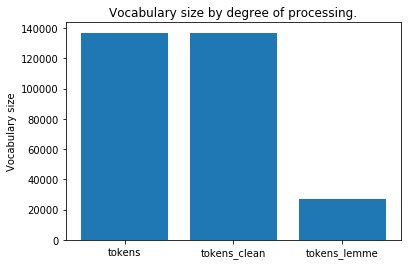

In [359]:
plt.bar(range(3), [len(VOCAB), len(VOCAB_CLEAN), len(VOCAB_LEMME)])
plt.xticks(range(3), LABELS)
plt.ylabel('Vocabulary size')
plt.xlabel('')
plt.title('Vocabulary size by degree of processing.')
plt.show()

#### sentence lengths

In [361]:
pd.Series(sentence_lengths).describe()

count    568454.000000
mean         83.006127
std          82.779668
min           3.000000
25%          34.000000
50%          58.000000
75%         101.000000
max        3519.000000
dtype: float64

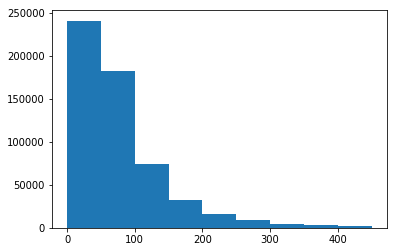

In [360]:
plt.hist(sentence_lengths, bins=np.arange(0, 500, 50))
plt.show()

In [130]:
sentence_lengths_pos = [len(tokens) for tokens in pos_data['tokens_flat']]
sentence_lengths_neu = [len(tokens) for tokens in neu_data['tokens_flat']]
sentence_lengths_neg = [len(tokens) for tokens in neg_data['tokens_flat']]
sentence_lengths_all = [sentence_lengths_pos, sentence_lengths_neu, sentence_lengths_neg]

In [132]:
print([np.mean(sen) for sen in sentence_lengths_all])
print([np.median(sen) for sen in sentence_lengths_all])

[79.90117108367491, 99.299999999999997, 91.333313017297073]
[55.0, 72.0, 66.0]


In [133]:
def show_plots(data_pts, n_row=1, n_col=3, figsize=(15, 6), title_name='Histogram'):
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    n_pts = n_row*n_col
    data_pts = data_pts[:n_pts]
    
    for i, data_pt in enumerate(data_pts):
        plt.subplot(n_row, n_col, i+1)
        plt.hist(data_pt, bins=np.arange(0,500,25))
        plt.title(title_name, fontsize=10)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)

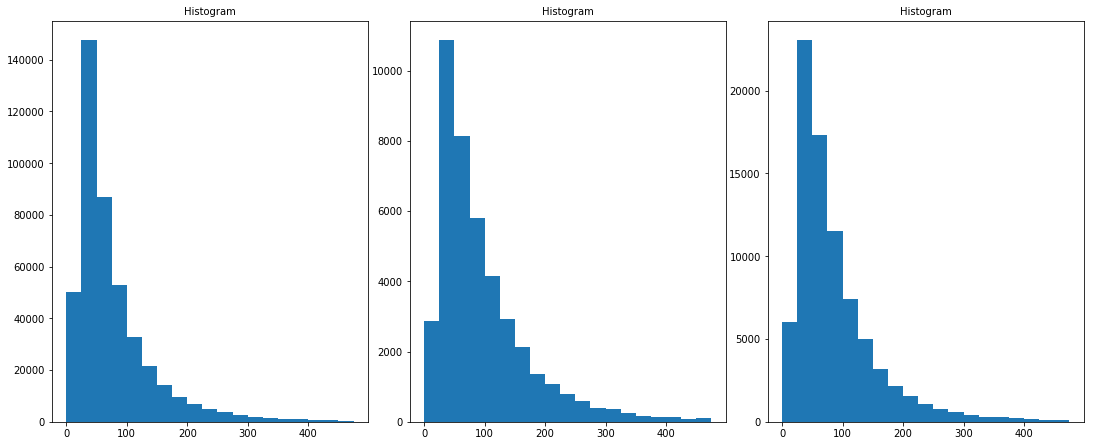

In [135]:
show_plots(sentence_lengths_all)

## 4. word embeddings

In [144]:
EMBEDDING_DIM=300

### 4.a. load word2vec (Google)

In [138]:
wor2vec_path = os.path.join(data_path, 'word2vec/GoogleNews-vectors-negative300.bin.gz')
word2vec = gensim.models.KeyedVectors.load_word2vec_format(wor2vec_path, binary=True)

### 4.b. load glove

In [139]:
def load_glove(glove_path):
    f = open(glove_path,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = [float(val) for val in splitLine[1:]]
        model[word] = embedding
    return model

In [142]:
glove_path = os.path.join(data_path, 'glove/glove.6B.300d.txt')

glove = load_glove(glove_path)

### 4.c. load word2vec (custom-made)

In [143]:
from gensim.models.word2vec import Word2Vec

# train custom-made word2vec
def train_word2vec_model(n_dim, min_count, list_sentences, corpus_size, epochs):
    vec_model = Word2Vec(size=n_dim, min_count=min_count)
    vec_model.build_vocab(list_sentences)
    vec_model.train(list_sentences, total_examples=corpus_size, epochs=epochs)
    return vec_model

In [145]:
cols = ['tokens' + syntax + '_flat' for syntax in syntaxes]
cols

['tokens_flat', 'tokens_clean_flat', 'tokens_lemme_flat']

In [146]:
w2v_custom = [train_word2vec_model(n_dim=EMBEDDING_DIM, min_count=10, list_sentences=list(data_clean[col]), corpus_size=len(all_words), epochs=10) for col in cols]

### 4.d. benchmark and visualize

In [179]:
embeddings_labels = ['w2v', 'amz', 'glv']

In [180]:
embedding_dict = {'w2v':word2vec, 'amz':w2v_custom, 'glv':glove}
embedding_dict_simple = {'w2v':word2vec, 'amz':w2v_custom[2], 'glv':glove}

In [203]:
def get_average_word2vec(tokens_list, w2v, generate_missing=False, k=300):

    if len(tokens_list) < 1:
        return np.zeros(k)

    if generate_missing:
        vectorized = [w2v[word] if word in w2v else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [w2v[word] if word in w2v else np.zeros(k) for word in tokens_list]

    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    return averaged

In [204]:
def average_vectors(vectors, k=300):
    length = len(vectors)
    if length > 0:
        try:
            summed = np.sum(vectors, axis=0)
            averaged = np.divide(summed, length)
        except:
            averaged = np.zeros(k)
    else:
        averaged = np.zeros(k)
    return averaged

In [205]:
def get_word2vec_embeddings(embedding_representation, list_sentences, flat=False, generate_missing=False):
    embeddings = [get_average_word2vec(sublist, embedding_representation, generate_missing=generate_missing) for sublist in list_sentences]
    if not flat:
        embeddings = average_vectors(embeddings)
    return embeddings

In [206]:
def add_embedding(df, embedding_representation, output_prefix, flat=False, generate_missing=False):
    #df[output_prefix] = df['tokens'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    #df[output_prefix + '_clean'] = df['tokens_clean'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    df[output_prefix + '_lemme'] = df['tokens_lemme'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    return df

In [207]:
def add_data_embeddings(df, embedding_dict, flat=False, generate_missing=False):
    for key, value in embedding_dict.items():
        print(' -- Adding ' + key +  ' embedding -- ')
        df = add_embedding(df, value, key)
    return df

In [208]:
data_clean = add_data_embeddings(data_clean, embedding_dict_simple)

 -- Adding w2v embedding -- 
 -- Adding amz embedding -- 
 -- Adding glv embedding -- 


In [247]:
data_clean.columns

Index(['ProductId', 'Score', 'Summary', 'Text', 'Sentiment', 'ClassLabel',
       'list_sentences', 'tokens', 'tokens_clean', 'tokens_lemme',
       'tokens_flat', 'tokens_clean_flat', 'tokens_lemme_flat', 'w2v_lemme',
       'amz_lemme', 'glv_lemme'],
      dtype='object')

In [214]:
embeddings_w2v, embeddings_amz, embeddings_glv = [data_clean[col + '_lemme'].tolist() for col in embeddings_labels]

In [215]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

%matplotlib inline
from pylab import *

In [228]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    print(color_mapper)
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['green','blue', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        green_patch = mpatches.Patch(color='green', label='Positive')
        red_patch = mpatches.Patch(color='red', label='Negative')
        blue_patch = mpatches.Patch(color='blue', label='Neutral')
        plt.legend(handles=[green_patch, red_patch, blue_patch])

In [229]:
x=embeddings_w2v
y=data_clean.ClassLabel.tolist()

{1: 0, 2: 1, 3: 2}


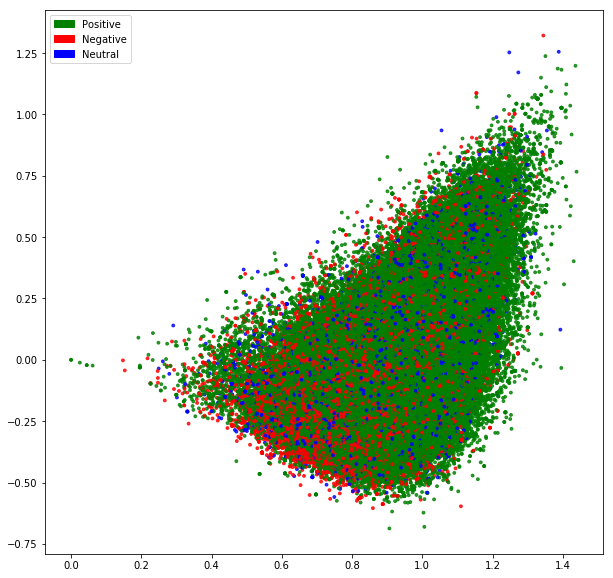

In [230]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(x, y)
plt.show()

## 5. balance dataset

In [231]:
output_label = 'Sentiment'

In [232]:
def balance_dataset(df, output_label, sampling_type):
    
    unique_outputs = list(set(df[output_label].tolist()))

    datasets = [df.loc[df[output_label]==item] for item in unique_outputs]
    sizes = [item.shape[0] for item in datasets]
    min_size = min(sizes)
    max_size = max(sizes)

    if sampling_type=="over":
        result_df = pd.concat([data.sample(max_size, replace=True) for data in datasets])
    elif sampling_type=="down":
        result_df = pd.concat([data.sample(min_size) for data in datasets])
        
    result_df.reset_index(drop=True, inplace=True)
    return result_df

In [233]:
balanced_data_clean = balance_dataset(data_clean, output_label, sampling_type="down")

In [234]:
print('Balanced dataset shape :', balanced_data_clean.shape)

Balanced dataset shape : (127920, 16)


In [235]:
balanced_data_clean.Sentiment.value_counts()

Neutral     42640
Negative    42640
Positive    42640
Name: Sentiment, dtype: int64

In [ ]:
x=balanced_data_clean
y=balanced_data_clean.ClassLabel.tolist()

In [ ]:
balanced_data_clean

fig = plt.figure(figsize=(10, 10))          
plot_LSA(x, y)
plt.show()

## 6. Classification tasks

**Vectors** : 
- `X_w2v`
- `X_amz`
- `X_glv`

**Labels** :
- `y`

In [237]:
X_w2v, X_amz, X_glv = [balanced_data_clean[col + '_lemme'].tolist() for col in embeddings_labels]
y = balanced_data_clean.ClassLabel.tolist()

In [240]:
from sklearn.model_selection import train_test_split

def generate_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    return X_train, X_test, y_train, y_test

In [245]:
X_w2v_train, X_w2v_test, y_train, y_test = generate_data(X_w2v, y)
X_amz_train, X_amz_test, _, _ = generate_data(X_amz, y)
X_glv_train, X_glv_test, _, _ = generate_data(X_glv, y)

### 6.a Starting simple : Logistic Regression and SVM

In [251]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

% time clf.fit(X_w2v_train, y_train)
y_w2v_predicted = clf.predict(X_w2v_test)

% time clf.fit(X_amz_train, y_train)
y_amz_predicted = clf.predict(X_amz_test)

% time clf.fit(X_glv_train, y_train)
y_glv_predicted = clf.predict(X_glv_test)

CPU times: user 14.1 s, sys: 55.1 s, total: 1min 9s
Wall time: 1min 45s
CPU times: user 13.9 s, sys: 41.9 s, total: 55.8 s
Wall time: 1min 17s
CPU times: user 14.1 s, sys: 44.2 s, total: 58.3 s
Wall time: 1min 43s


In [252]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [253]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_w2v_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.640, recall = 0.641, f1 = 0.640


In [254]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_amz_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.672, precision = 0.672, recall = 0.672, f1 = 0.672


In [255]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_glv_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.631, precision = 0.631, recall = 0.631, f1 = 0.631


In [258]:
from sklearn import svm
clf = svm.LinearSVC(random_state=40)

% time clf.fit(X_w2v_train, y_train)
y_w2v_predicted = clf.predict(X_w2v_test)

% time clf.fit(X_amz_train, y_train)
y_amz_predicted = clf.predict(X_amz_test)

% time clf.fit(X_glv_train, y_train)
y_glv_predicted = clf.predict(X_glv_test)

CPU times: user 52.6 s, sys: 2.85 s, total: 55.4 s
Wall time: 59 s
CPU times: user 5min 20s, sys: 3.76 s, total: 5min 24s
Wall time: 5min 28s
CPU times: user 4min 26s, sys: 3.66 s, total: 4min 29s
Wall time: 4min 33s


In [253]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_w2v_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.640, recall = 0.641, f1 = 0.640


In [254]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_amz_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.672, precision = 0.672, recall = 0.672, f1 = 0.672


In [255]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_glv_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.631, precision = 0.631, recall = 0.631, f1 = 0.631
